In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
class CausalCNNRegressor:
    
    def load(self, num_clauses, num_mc_runs, start_temperature, number, test_size = .2):
        # Loads and prepares data. The path should be adjusted depending on where your 
        # data is.
        file_name = f'ec3_stim_anneal_spins{7}_clauses{num_clauses}' + \
            f'_runs{num_mc_runs}_temp{start_temperature}_{number}'
        path = f'../../../projects/ML/data/MC_ML/{file_name}.npz'
        data = np.load(path)
        
        ftrs = data['res_mc_timelines']
        lbls = data['res_fidelity'][:, -1]
        
        # Perform min max normalization for the features
        ftrs = ftrs - ftrs.min()
        ftrs /= ftrs.max() - ftrs.min()
        
        # Split train/test data for the full Hamiltonian.
        X_train, X_test, Y_train, Y_test = train_test_split(
            ftrs, lbls, test_size = test_size)
        
        self.X_train, self.X_test = X_train, X_test 
        self.Y_train, self.Y_test = Y_train, Y_test 

    def build_model(self, learn_rate, num_conv, num_dense):
        
        keras.backend.clear_session()
        model = keras.Sequential(name='Causal_CNN_regressor')
        
        model.add(keras.layers.Conv1D(1, (num_conv,), activation = 'sigmoid', 
            padding = 'causal', strides = num_conv))
        model.add(keras.layers.Conv1D(1, (num_conv,), activation = 'sigmoid', 
            padding = 'causal', strides = num_conv))
        model.add(keras.layers.Conv1D(1, (num_conv,), activation = 'sigmoid', 
            padding = 'causal', strides = num_conv))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(num_dense, activation = 'relu'))
        model.add(keras.layers.Dense(num_dense, activation = 'relu'))
        model.add(keras.layers.Dense(1))
        
        model.compile(loss='mae', optimizer = keras.optimizers.Adam(learn_rate), 
            metrics=['mae'])

        self.model = model
        
    def training(self, epochs, batch_size = 128, early = True):
        
        # Introduce early stopping
        stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
            patience = 100)

        callbacks =[]
        if early:
            callbacks += [stop_early]

        self.hist = self.model.fit(self.X_train, self.Y_train, epochs = epochs,
            verbose = 0, validation_split = .2, batch_size = batch_size,\
            callbacks = callbacks)
        

In [8]:
def regression(num_clauses, num_mc_runs, start_temperature, number, learn_rate, 
        num_conv, num_dense, num_epochs):
    regressor = CausalCNNRegressor()
    regressor.load(num_clauses, num_mc_runs, start_temperature, number)
    regressor.build_model(learn_rate, num_conv, num_dense)
    regressor.training(num_epochs)
    
    return regressor

In [9]:
# Sample data
reg = regression(5, 10000, 10, 1, .001, 4, 16, 1000)

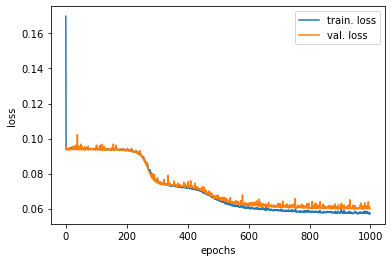

In [13]:
plt.plot(reg.hist.history['loss'], label = 'train. loss')
plt.plot(reg.hist.history['val_loss'], label = 'val. loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Text(0.5, 1.0, 'test data')

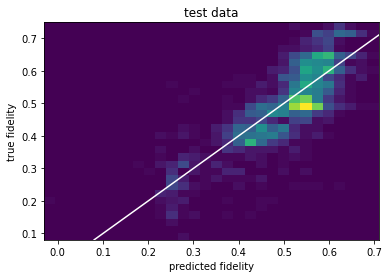

In [12]:
plt.hist2d(reg.model.predict(reg.X_test).flatten(), reg.Y_test, bins = 30);
plt.plot([reg.Y_test.min(), reg.Y_test.max()], [reg.Y_test.min(), reg.Y_test.max()], 'w')
plt.xlabel('predicted fidelity')
plt.ylabel('true fidelity')
plt.title('test data')